<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#随机抽样" data-toc-modified-id="随机抽样-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>随机抽样</a></span><ul class="toc-item"><li><span><a href="#代码" data-toc-modified-id="代码-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>代码</a></span></li><li><span><a href="#测试" data-toc-modified-id="测试-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>测试</a></span></li></ul></li><li><span><a href="#逐项遍历" data-toc-modified-id="逐项遍历-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>逐项遍历</a></span></li><li><span><a href="#K-fold-交叉检验" data-toc-modified-id="K-fold-交叉检验-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>K-fold 交叉检验</a></span></li><li><span><a href="#滚雪球抽样" data-toc-modified-id="滚雪球抽样-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>滚雪球抽样</a></span></li><li><span><a href="#熟识者抽样" data-toc-modified-id="熟识者抽样-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>熟识者抽样</a></span></li><li><span><a href="#随机游走采样" data-toc-modified-id="随机游走采样-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>随机游走采样</a></span></li><li><span><a href="#基于路径抽样" data-toc-modified-id="基于路径抽样-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>基于路径抽样</a></span></li></ul></div>

* 为了测试算法的性能， 需要对数据集进行划分



* 划分方法的不同，算法的表现也不同



# 随机抽样

*  最常用的方法

* 含有 M 条边， 假设划分的比例为 p, M 条 已知边中随机选择 pM 条边构成测试集， 保证每条边被选进测试集的概率相同。

* 有时会有一些限制条件： 抽样之后网络的连通性


## 代码

* 参照 《链路预测》 书完成

* 原书有较为完整 Matlab 代码



In [23]:
from scipy import sparse
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def spones(array):
    """
    将矩阵中的非零元素全部替换为 1 
    """
    sparse_array = sparse.csr_matrix(array)  # 转换为稀疏矩阵
    sparse_array.data.fill(1)  # 稀疏矩阵全部替换为 1
    array = sparse_array.toarray()  # 返回密集矩阵

    return array


def DivideNet(MatrixAdajacency, ratioTrain):
    """
    划分训练集和测试集
    
    保证网络训练集连通
    """

    # 测试集的连边数目
    num_testlinks = int(
        (1 - ratioTrain) * np.count_nonzero(MatrixAdajacency) / 2)
    # 将邻接矩阵中所有的边找出来 存储到 linklist 中
    linklist = [list(i) for i in np.argwhere(np.triu(MatrixAdajacency))]
    # 为每条边都设置标志位 ， 判断是否能够删除
    MatrixAdajacency_test = np.zeros(shape=(np.shape(MatrixAdajacency)[0],
                                            np.shape(MatrixAdajacency)[1]))

    while (np.count_nonzero(MatrixAdajacency_test) < num_testlinks):

        ### 随机选择一条边
        link_index = int(np.random.rand(1) * len(linklist))
        uid1 = linklist[link_index][0]  # 边两端的节点 1
        uid2 = linklist[link_index][1]

        ### 判断所选边两端节点 uid1 和 uid2 是否可达， 若可达则放入测试集， 否则重新选边
        # 将这条边从网络中挖去，
        MatrixAdajacency[uid1, uid2] = 0
        MatrixAdajacency[uid2, uid1] = 0

        tempvector = MatrixAdajacency[uid1]  # 取出 uid1  一步可达的点 构成一维向量
        sign = 0  # 标记此边是否可以被移除，  sign = 0 表示不可， sign = 1 表示可以
        uid1TOuid2 = np.dot(tempvector,
                            MatrixAdajacency) + tempvector  # 表示 uid1 2步内可达的点

        if uid1TOuid2[0, uid2] > 0:
            sign = 1  # 两步即可到达
        else:

            count = 1
            while (len((spones(uid1TOuid2) - tempvector).nonzero()[0]) != 0):
                # 直到可达的点到达稳定状态， 仍然不能到达 uid2， 此边就不能删除
                tempvector = spones(uid1TOuid2)
                uid1TOuid2 = np.dot(
                    tempvector, MatrixAdajacency) + tempvector  # 表示 K 步 内可达的点
                count += 1
                if uid1TOuid2[0, uid2] > 0:
                    sign = 1  # 某步内可以到达
                    break

                if count >= MatrixAdajacency.shape[0]:
                    print("不可达" + str([uid1, uid2]))
                    sign = 0

        ### 如果边可以删除， 将其放入测试集中， 并从 link 集中删除
        if sign == 1:
            linklist.pop(link_index)
            MatrixAdajacency_test[uid1, uid2] = 1

        ### 如果不可以删除， 恢复原始矩阵， 也从 link 集中删除
        else:
            linklist.pop(link_index)
            MatrixAdajacency[uid1, uid2] = 1
            MatrixAdajacency[uid2, uid1] = 1

    MatrixAdajacency_Train = MatrixAdajacency
    MatrixAdajacency_Test = MatrixAdajacency_test + MatrixAdajacency_test.T

    print('    训练集计划边数：' +
          str(np.count_nonzero(MatrixAdajacency) - num_testlinks))
    print('    训练集实际边数：' + str(np.count_nonzero(MatrixAdajacency_Train)))
    print('    测试集计划边数：' + str(num_testlinks))
    print('    测试集实际边数：' + str(np.count_nonzero(MatrixAdajacency_Test)))

    return MatrixAdajacency_Train, MatrixAdajacency_Test


def check_symmetric(a, tol=1e-8):
    """
    检查是否是 对称矩阵
    """
    return np.allclose(a, a.T, atol=tol)

-------

##  测试


In [9]:
edge_lst = []
with open("lit-bm-13.txt","r") as file_txt: # 蛋白质相互作用数据集
    for i, line in enumerate(file_txt.readlines()):
        edge_tpl =  str(line.split()[0]), str(line.split()[1]),{'weight': 1}
        edge_lst.append(edge_tpl)

F = nx.from_edgelist(edge_lst)
df = nx.to_pandas_adjacency(F)
data = np.matrix(df)

In [12]:
train , test = DivideNet(data.copy(), 0.9)

    训练集邻接矩阵：(3391, 3391)
    训练集计划边数：7963
    训练集实际边数：8427
    测试集邻接矩阵：(3391, 3391)
    测试集计划边数：464
    测试集实际边数：433.5


In [18]:
check_symmetric(train)

True

In [19]:
def Cn(MatrixAdjacency_Train):
    """
    共同邻居算法
    """
    Matrix_similarity = np.dot(MatrixAdjacency_Train,MatrixAdjacency_Train)
    return Matrix_similarity

In [20]:
Matrix_similarity = Cn(train)

In [21]:
Matrix_similarity

matrix([[ 2.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1., 18., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [26]:
np.count_nonzero(Matrix_similarity)

43303

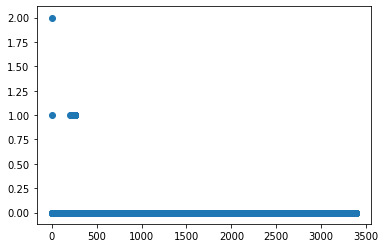

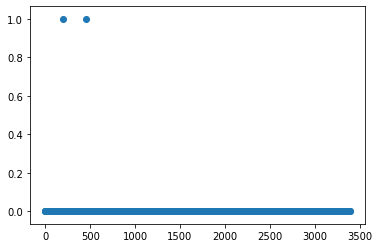

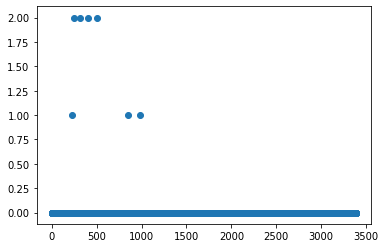

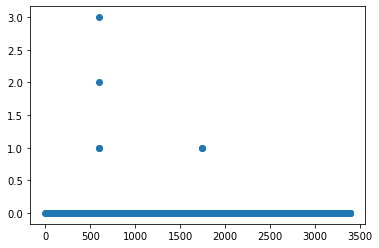

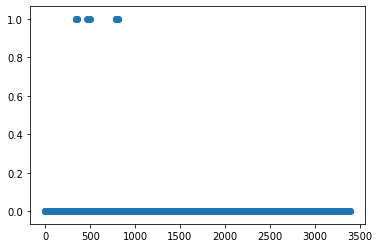

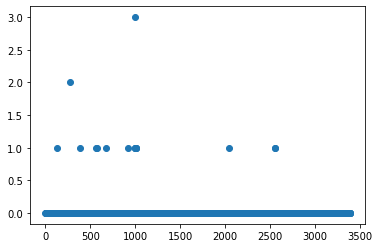

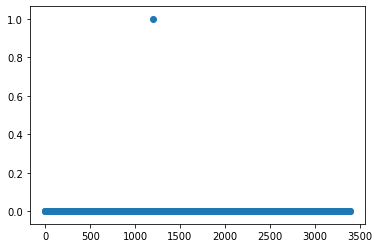

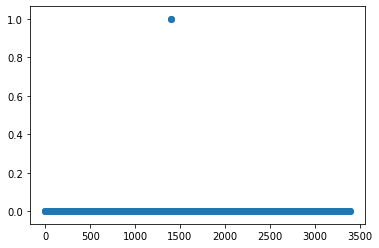

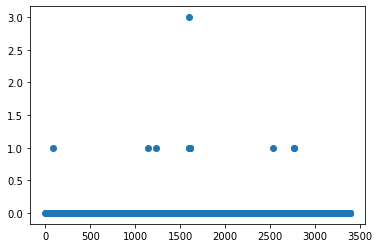

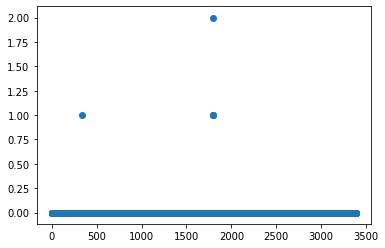

In [25]:
for i in range(10):
    plt.figure(i)
    plt.scatter([i for i in range(3391)],np.array(Matrix_similarity[:,i* 200]).ravel())

----

-----

# 逐项遍历

> 类似于机器学习中的 留一取样

* 规模较小的网络中， 更加精确的办法是 逐项遍历




*  每次从网络中选取一条边作为测试边， 其余的边构成训练集。 一条测试边进行测试得到一个预测精度， 遍历网络中的所有 M 条边。得到一个预测精度的平均值



* 计算复杂度特别高， 只适合小网络


---------

# K-fold 交叉检验

* 将样本集随机分成 k 份， 选择其中的一份作为测试集，其余的 k-1 作为训练集



* 试验重复 k 次， 计算精度的平均值



* 保证了每条边都能作为测试边， 随机采样的做不到



* 常用 10折检验



------

# 滚雪球抽样

> 类似于 广度优先搜索


* 初始的时候，随机选择一个或者一组节点构成样本集， 之后遍历样本集的每一个节点的所有邻居节点



* 重复上述过程，直到样本集中的样本数量达到要求



* 这种抽样的方法得到的是节点


-----

# 熟识者抽样


* 倾向于把 度小的节点之间的连边放入到训练集，度大的节点之间的连边放入到测试集


* 上述倾向也可以人为调整反过来

--------

# 随机游走采样


> 通过一个粒子在网络上随机游走进行抽样

* 1. 随机选择一个节点， 并放置一个粒子



* 2. 粒子随机游走到当前节点的一个邻居节点， 粒子经过的边放入到训练集中



* 3. 重复2 ， 直到训练集中的边的数目满足要求


**保证训练集的连通性， 但是可能会丢失一些节点**




-----

# 基于路径抽样


> 一般而言， 一条链路上如果包含的信息越多， 挑选出来的概率越大


* 每一步随机选择两个节点， 一个视为信息报传输的起点， 一个视为终点。



* 信息包选择一条最短路径从起点到终点



* 每条边被信息包经过一次分数加1 



* 分数值大于一定的阈值的边可以被加入到训练集



**最短路径上出现次数最多的边被选入到训练集之中**